<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Our first neural architecture

We will build a simple neural architecture to solve a problem in linear regression.

In [2]:
from week_3.approximator.regression_network import SimpleFeedForwardNet, \
                                                    SimpleNumpyDataset

import numpy as np
import torch

from torch.nn import MSELoss
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

## Batch Gradient Descent

We will use the california housing dataset for building this neural network regression model

Let's go through preprocess_data to understand the transformations being done on the ingested raw data

In [3]:
from week_3.california_housing.pre_process import preprocess_data
from week_3.california_housing.ingest_data import ingest_cal_housing_data

In [4]:
data = ingest_cal_housing_data()
preprocessed_data = preprocess_data(data)
x = preprocessed_data.drop(['y_target'], axis=1).to_numpy(dtype=np.float32)
y = preprocessed_data[['y_target']].to_numpy(dtype=np.float32)

In [5]:
dim_x = x.shape[1]
X_tensor = torch.from_numpy(x).reshape(-1, dim_x)
y_tensor = torch.from_numpy(y)

In [6]:
# Get the training parts ready
network = SimpleFeedForwardNet(input_dimension=dim_x, output_dimension=1)
print(network)
network.activation = torch.relu # Rectified Linear Unit
loss_function = MSELoss()
optimizer = Adam(network.parameters(), lr=0.001, weight_decay=0.001)

# Let us now train the network
losses = []
epochs = 101
drop_out = 0.1
for epoch in range(epochs):

    optimizer.zero_grad()  # reset the gradients
    results = network(X_tensor, drop_out)  # get predictions
    loss = loss_function(results, y_tensor)  # estimate loss
    loss.backward()  # back-propagate gradients
    optimizer.step()  # update the parameter values (gradient-descent)
    losses.append(loss.data)  # keep track of the loss of this epoch
    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

SimpleFeedForwardNet(
  (fc0): Linear(in_features=13, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
--------------------------------------------------------------------------------------
| LAYER  |  IN FEATURES   |  OUT FEATURES  |  WEIGHTS   |   BIASES   | TOTAL PARAMS |
--------------------------------------------------------------------------------------
|  fc0   |       13       |      128       |    1664    |    128     |     1792     |
|  fc1   |      128       |       64       |    8192    |     64     |     8256     |
|  fc2   |       64       |       16       |    1024    |     16     |     1040     |
|  fc3   |       16       |       1        |     16     |     1      |      17      |
--------------------------------------------------------------------------------------
                          TOTAL MODEL PARAME

### Plot the results of batch gradient descent on the data

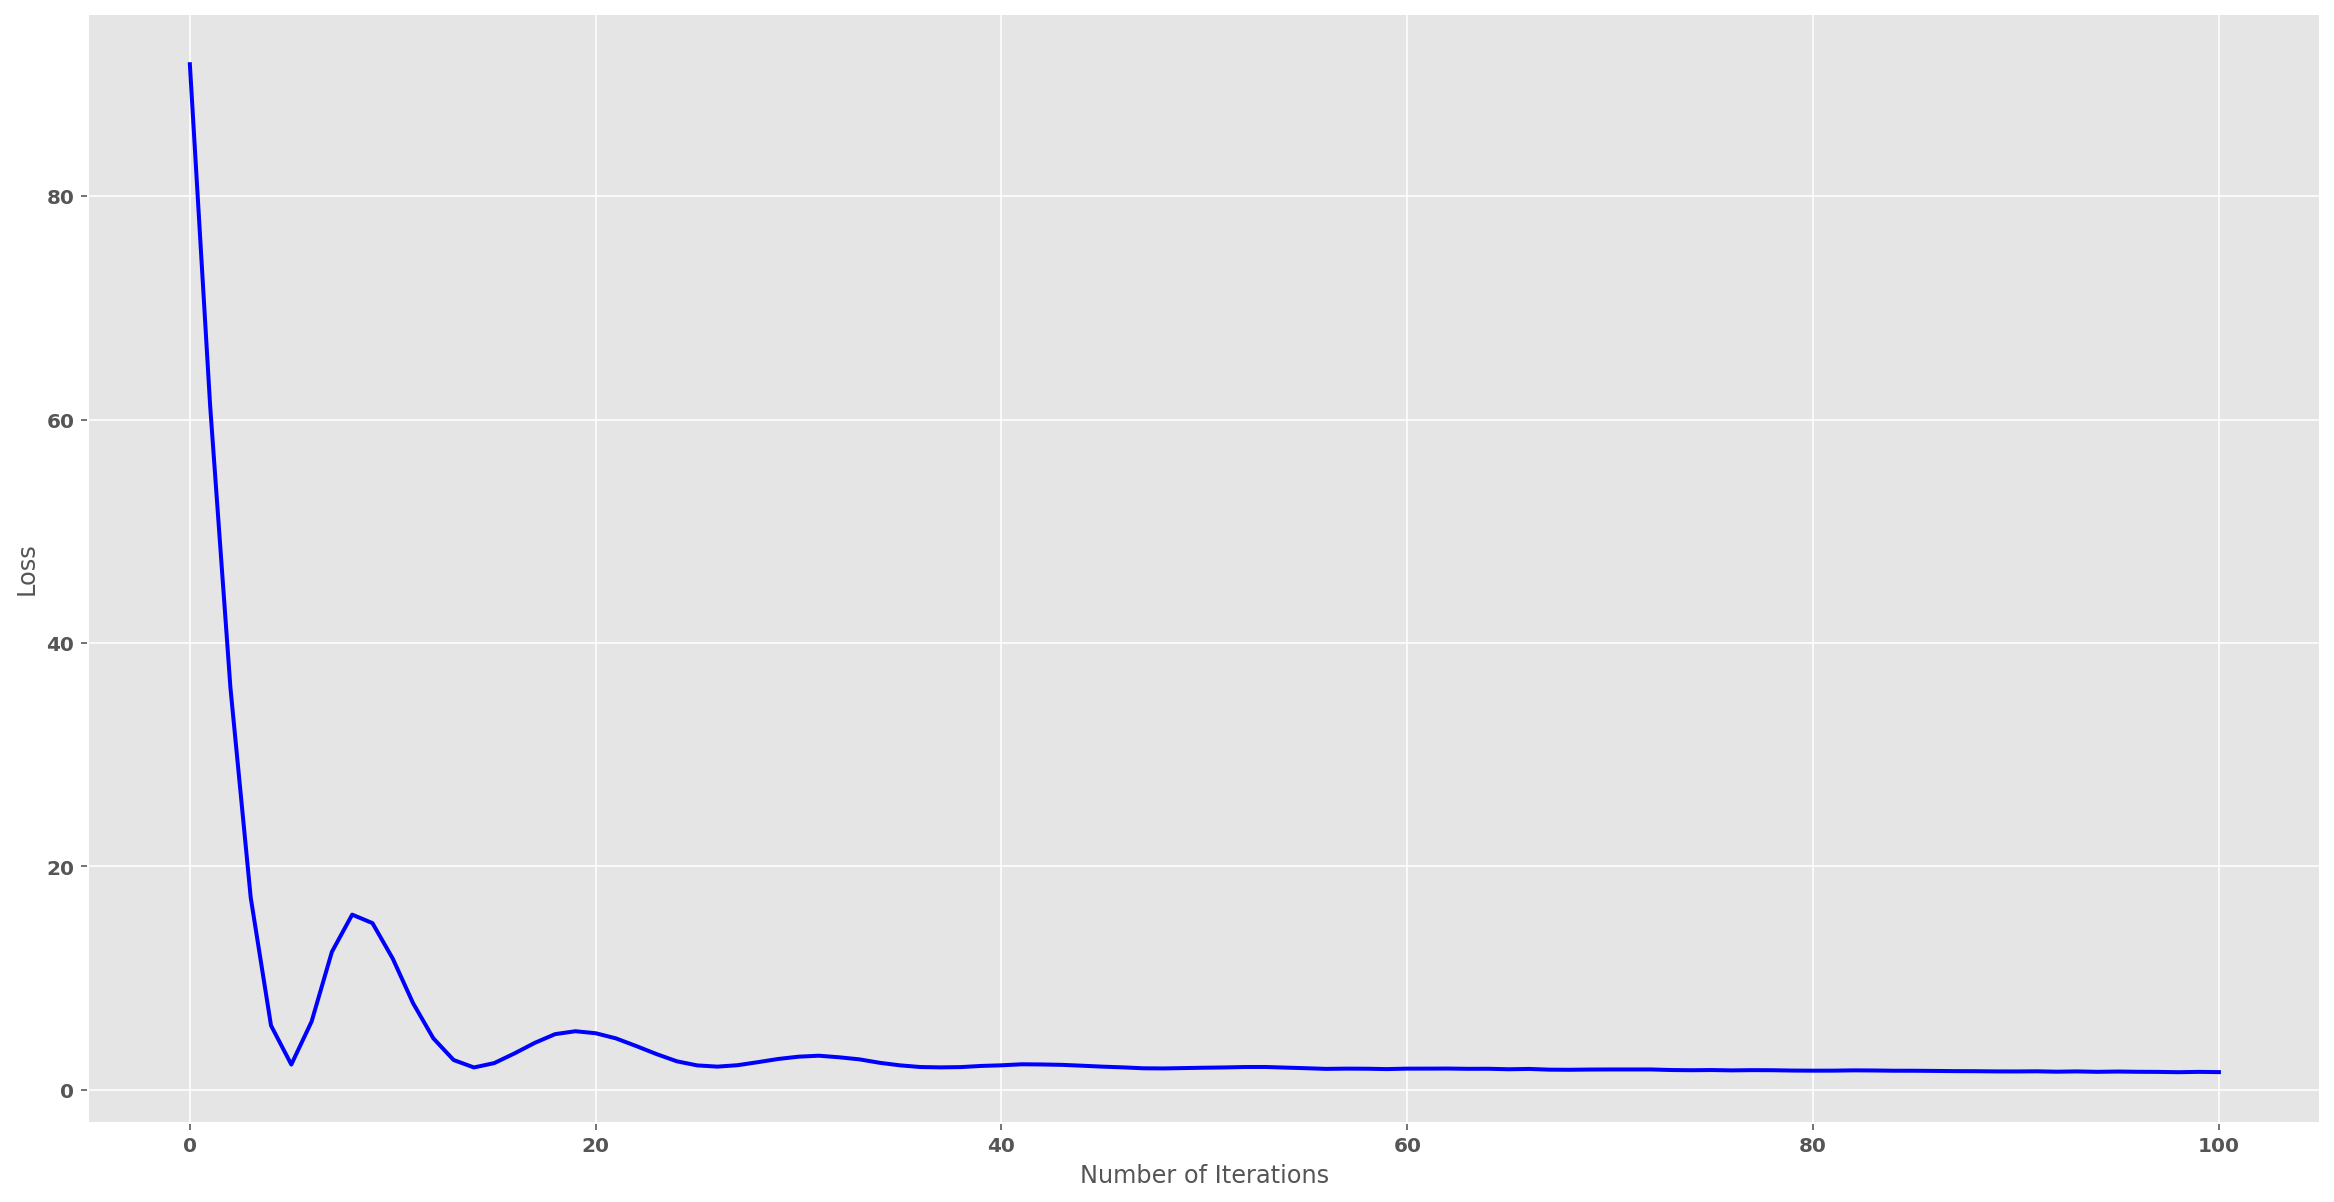

In [7]:
from week_3.approximator.regression_network import create_plots

create_plots(epochs, losses)

## Mini-batch Gradient Descent

Here, at each step, we learn from from mini batches of data. So, for this, the dataloader returns data in small batches. The mini-batch size is specified in the pytorch dataloader by the parameter `batch_size`


In [8]:
dataset = SimpleNumpyDataset(x, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)


epochs = 101
drop_out = 0.1
# Get the training parts ready
network = SimpleFeedForwardNet(input_dimension=dim_x, output_dimension=1)
print(network)
loss_function = MSELoss()
optimizer = Adam(network.parameters(), lr=0.001, weight_decay=0.001)
losses = []
epoch_losses = []
steps = 0
for epoch in range(epochs):
    start = True
    epoch_loss =0
    for data, labels in loader:
        optimizer.zero_grad()  # reset the parameter gradients
        results = network(data, drop_out)  # get predictions
        loss = loss_function(results, labels)  # estimate loss
        loss.backward()  # back-propagate gradients
        optimizer.step()  # update the parameter values (gradient-descent)
        losses.append(loss.data)  # keep track of the loss of this epoch
        epoch_loss += loss.data
        if epoch % 10 == 0 and start:
            print('epoch {}, loss {}'.format(epoch, loss.data))
        start = False
        steps +=1
    epoch_loss = epoch_loss / len(loader)
    epoch_losses.append(epoch_loss)

SimpleFeedForwardNet(
  (fc0): Linear(in_features=13, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
--------------------------------------------------------------------------------------
| LAYER  |  IN FEATURES   |  OUT FEATURES  |  WEIGHTS   |   BIASES   | TOTAL PARAMS |
--------------------------------------------------------------------------------------
|  fc0   |       13       |      128       |    1664    |    128     |     1792     |
|  fc1   |      128       |       64       |    8192    |     64     |     8256     |
|  fc2   |       64       |       16       |    1024    |     16     |     1040     |
|  fc3   |       16       |       1        |     16     |     1      |      17      |
--------------------------------------------------------------------------------------
                          TOTAL MODEL PARAME

### Let us now see how well the model has learned from the data.

### Plot the results of MINI-BATCH gradient descent on the data

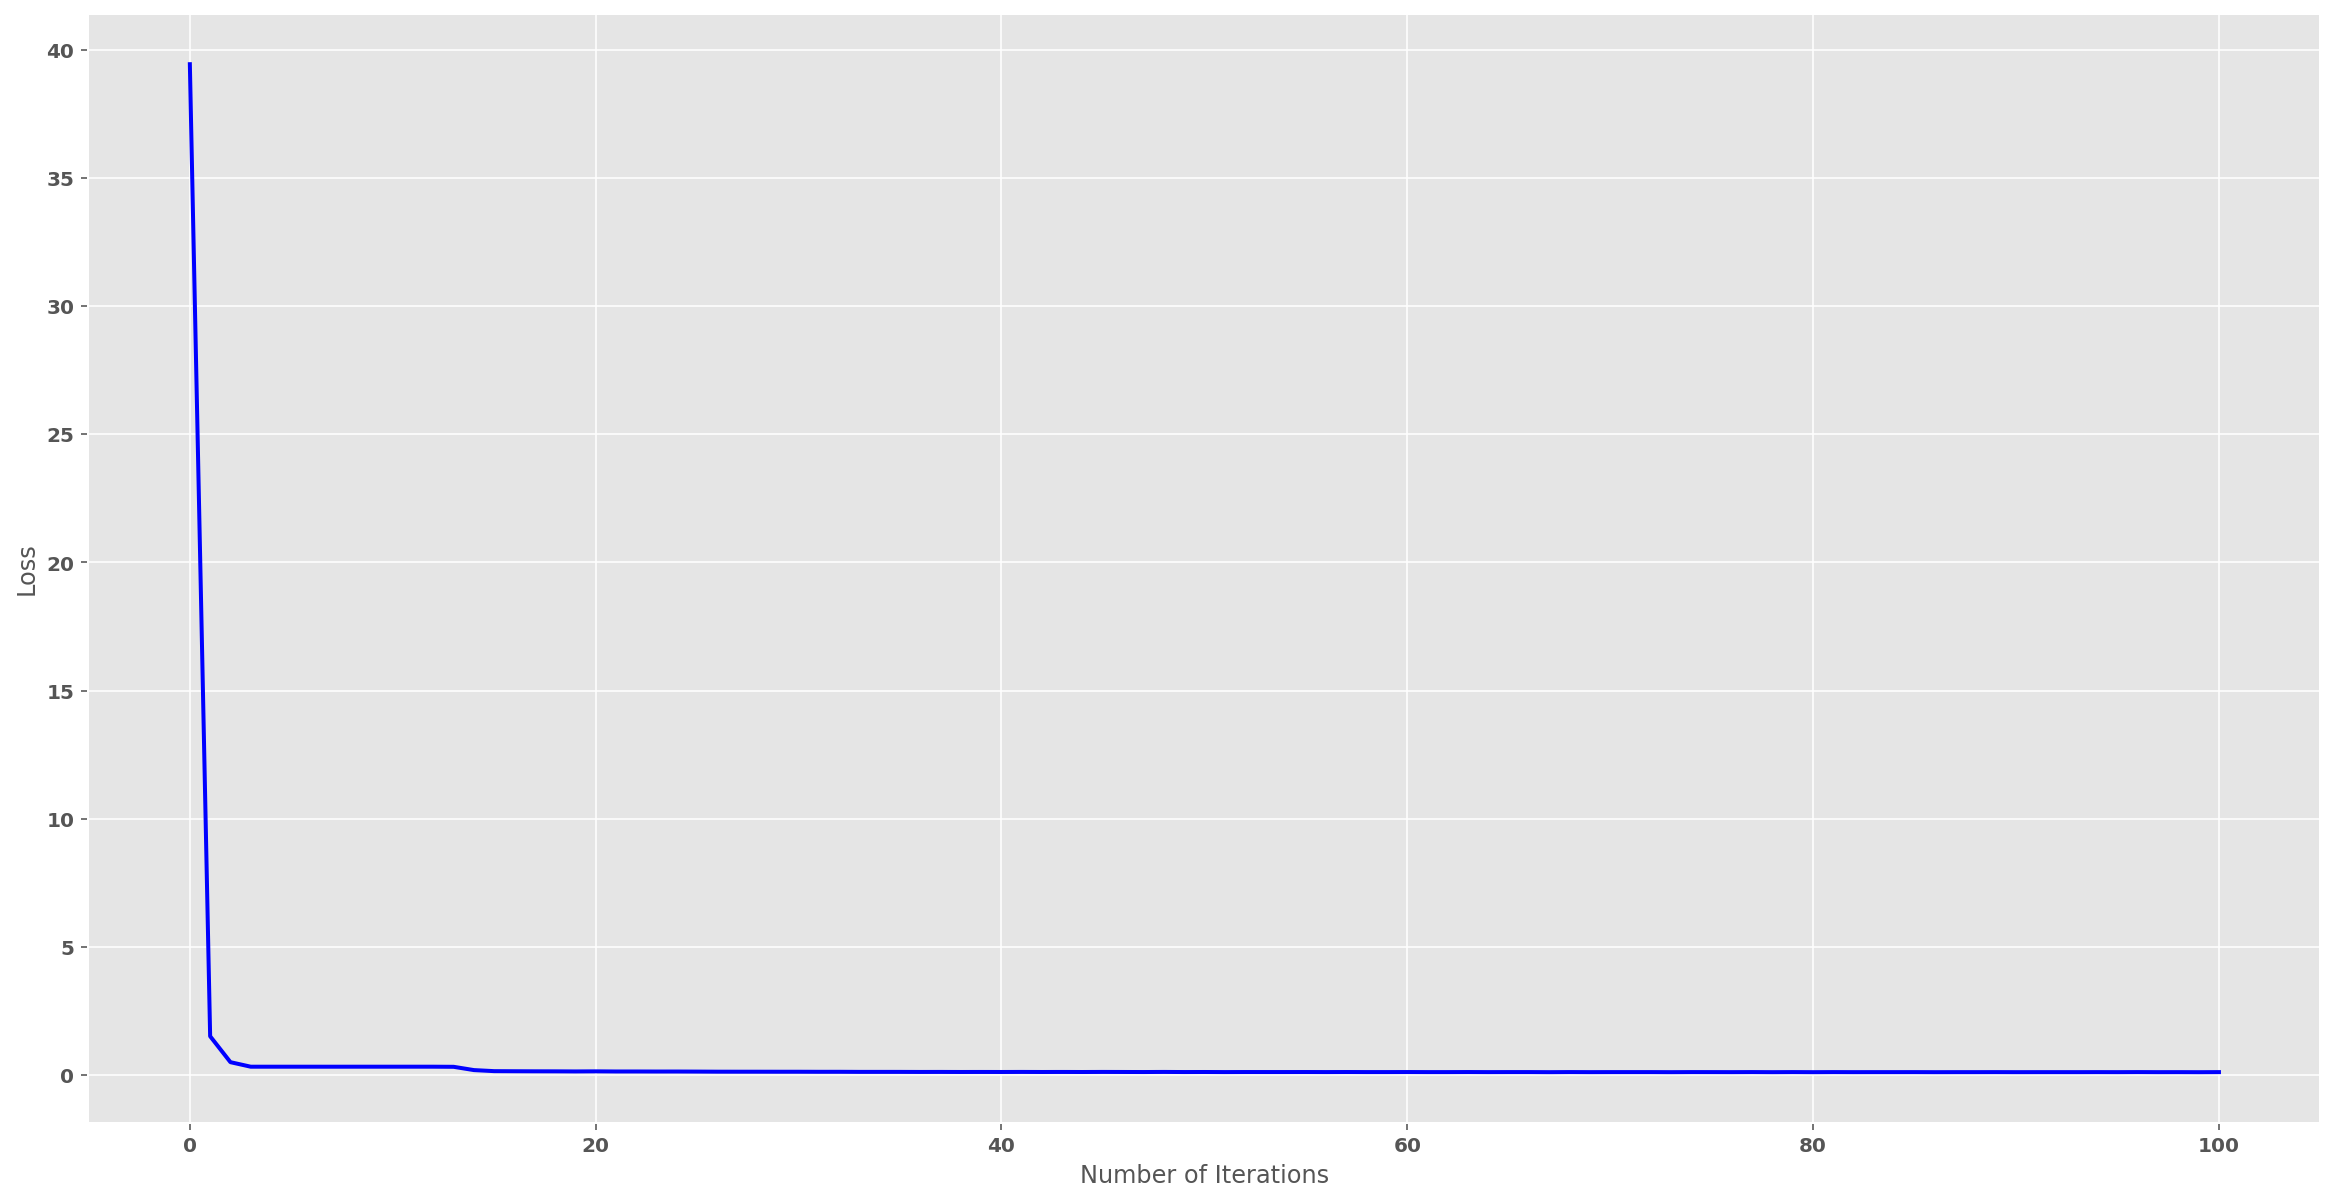

In [9]:
create_plots(epochs, epoch_losses)

## Stochastic Gradient Descent

Here, each step of learning is from one datum. So an epoch will have as many steps as the training sample size. Let us see how well it does.


In [10]:
# Note how we have set the mini-batch size to 1!
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

epochs = 101
drop_out = 0.1
# Get the training parts ready
network = SimpleFeedForwardNet(input_dimension=dim_x, output_dimension=1)
print(network)
loss_function = MSELoss()
optimizer = Adam(network.parameters(), lr=0.001, weight_decay=0.001)
losses = []
epoch_losses = []
steps = 0
for epoch in range(epochs):
    start = True
    epoch_loss =0
    for data, labels in loader:
        optimizer.zero_grad()  # reset the parameter gradients
        results = network(data, drop_out)  # get predictions
        loss = loss_function(results, labels)  # estimate loss
        loss.backward()  # back-propagate gradients
        optimizer.step()  # update the parameter values (gradient-descent)
        losses.append(loss.data)  # keep track of the loss of this epoch
        epoch_loss += loss.data
        if epoch % 10 == 0 and start:
            print('epoch {}, loss {}'.format(epoch, loss.data))
        start = False
        steps +=1
    epoch_loss = epoch_loss / len(loader)
    epoch_losses.append(epoch_loss)

SimpleFeedForwardNet(
  (fc0): Linear(in_features=13, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
--------------------------------------------------------------------------------------
| LAYER  |  IN FEATURES   |  OUT FEATURES  |  WEIGHTS   |   BIASES   | TOTAL PARAMS |
--------------------------------------------------------------------------------------
|  fc0   |       13       |      128       |    1664    |    128     |     1792     |
|  fc1   |      128       |       64       |    8192    |     64     |     8256     |
|  fc2   |       64       |       16       |    1024    |     16     |     1040     |
|  fc3   |       16       |       1        |     16     |     1      |      17      |
--------------------------------------------------------------------------------------
                          TOTAL MODEL PARAME

**Note how slow the training has gone, since we now have a huge number of steps.**

### Let us now see how effective the SGD optimizer has been

### Plot the results of Stochastic gradient descent optimization based learning from the data

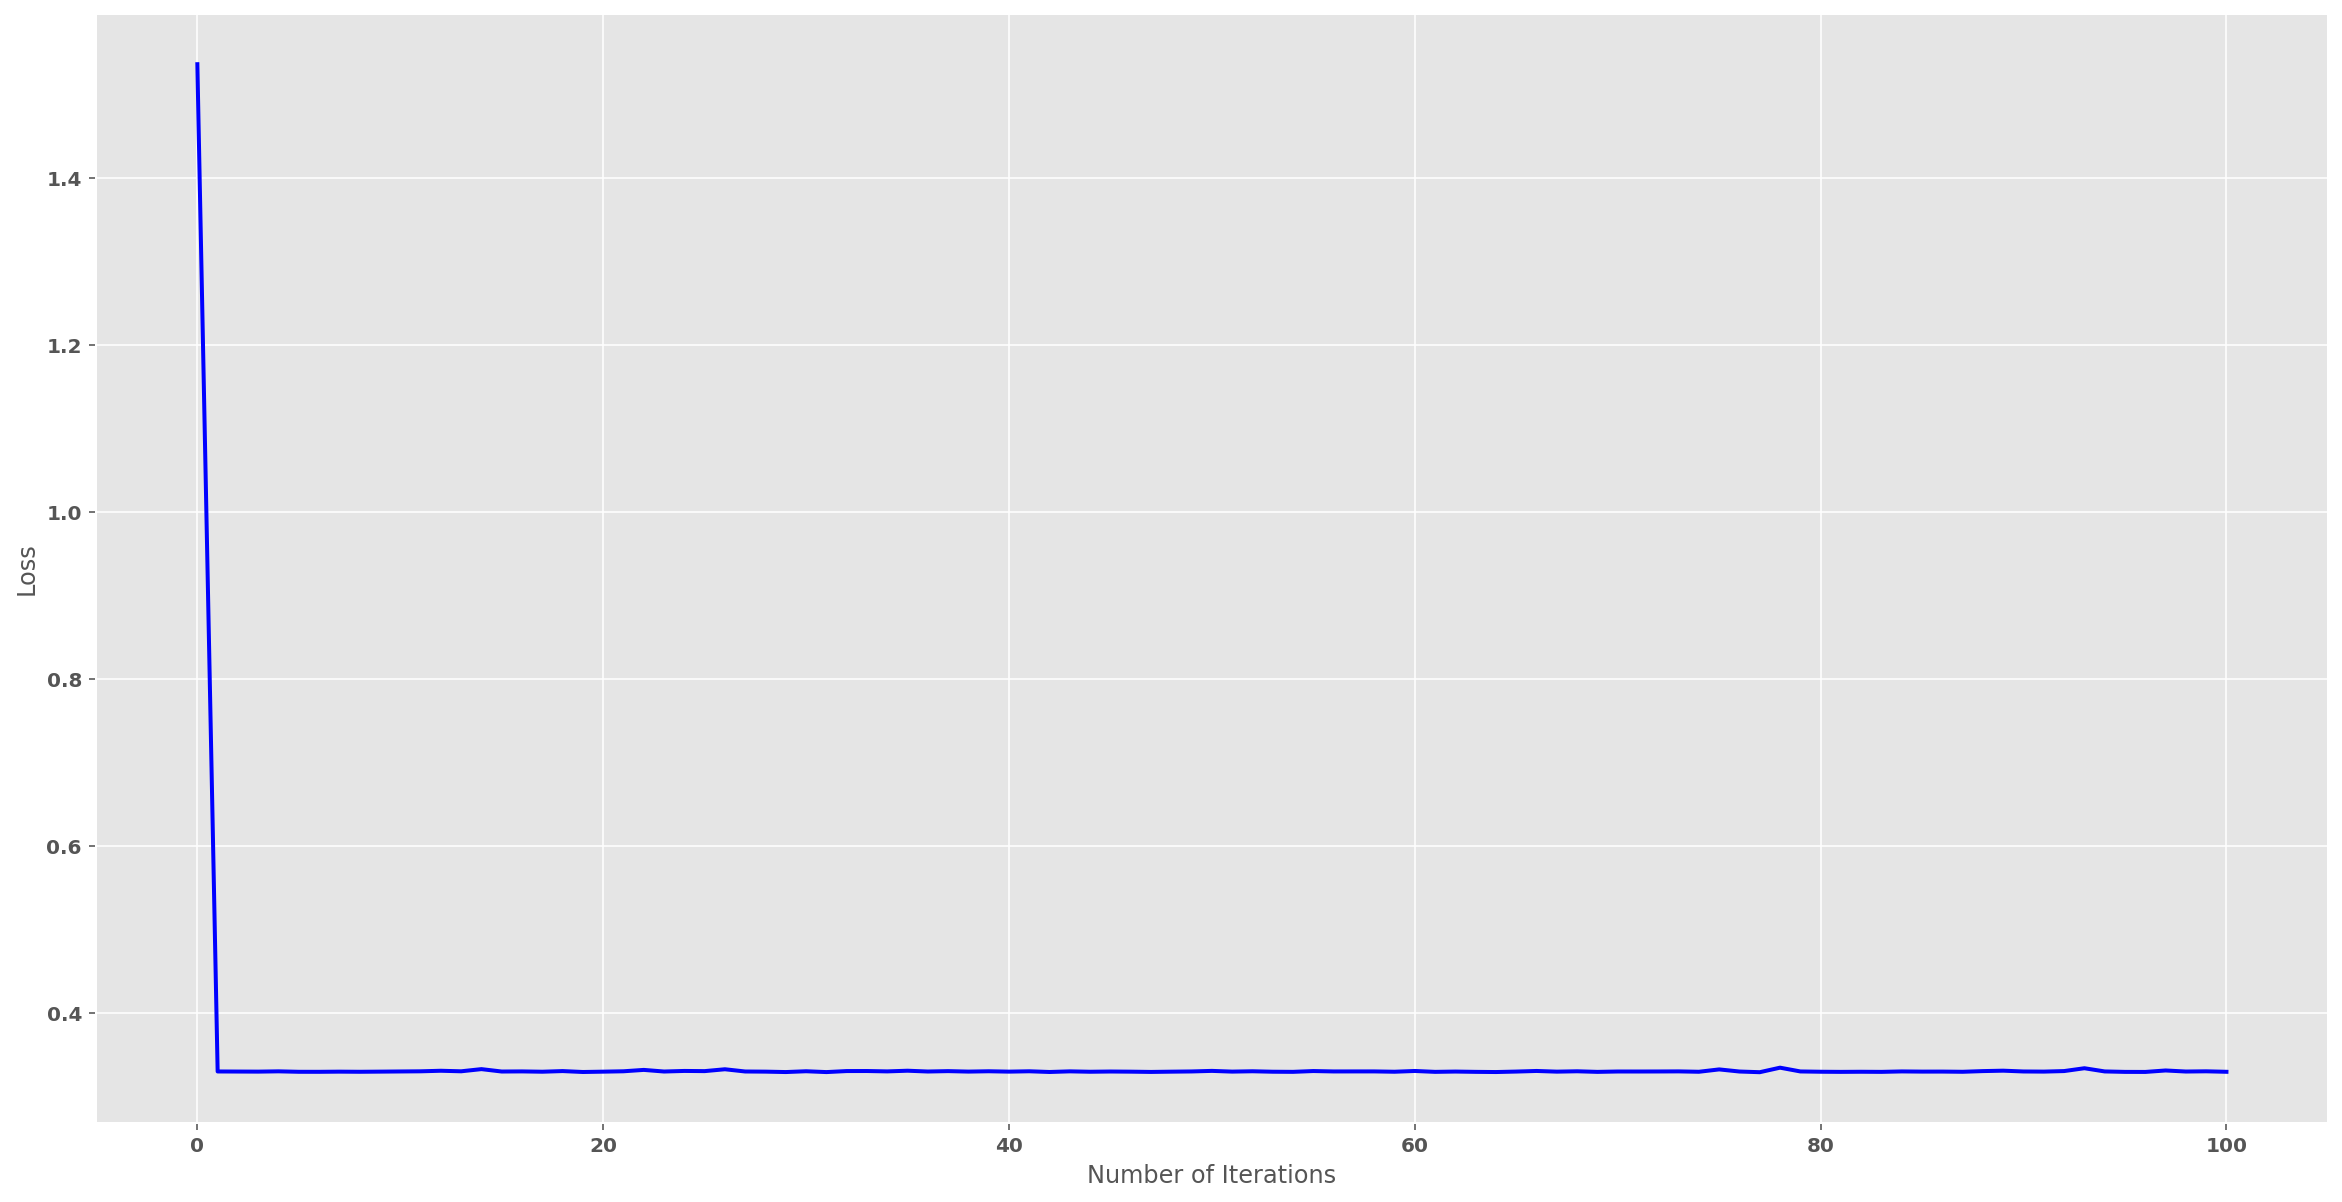

In [11]:
create_plots(epochs, epoch_losses)